### Entrenamiento del modelo

In [2]:
import cv2
import os
import re
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# -- Preparatory code --
# Model configuration
batch_size = 150
no_epochs = 20
learning_rate = 0.001
no_classes = 2
validation_split = 0.2
verbosity = 1
sample_shape = (372, 18, 32, 3)

Format of the data must be: input_shape = (number of videos, number of frames per video, height, width, channels)

That is to say: batch size, frames, height, width, channels)

input_shape = (20, 372, 18, 32, 3)

In [4]:
def video_to_array(filename):
    cap = cv2.VideoCapture(filename)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_array = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('float32'))

    fc = 0
    ret = True

    while (fc < frameCount  and ret):
        ret, video_array[fc] = cap.read()
        fc += 1

    cap.release()

    return video_array

Work to do in order to define X and Y --> transform videos into arrays + get corresponding labels for each one

In [4]:
dirname = os.path.join(os.getcwd(), 'Dataset')
vidpath = dirname + os.sep

videos = []
directories = []
dircount = []
prevRoot=''
cant=0

print("Leyendo videos de ", vidpath)

for root, dirnames, filenames in os.walk(vidpath):
    for filename in filenames:
        if re.search("\.(mp4|mpeg|avi)$", filename):
            if prevRoot != root:
                if prevRoot != '':
                    print(prevRoot, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
            cant=cant+1
            filepath = os.path.join(root, filename)
            video = video_to_array(filepath)
            video = video/255  # Pasar a negro o blanco (dentro del intervalo [0,1])
            videos.append(video)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
print(prevRoot, cant)
dircount.append(cant)
dircount = dircount[1:]
print('Directorios leidos:',len(directories))
print("Videos en cada directorio", dircount)
print('Suma Total de videos en subdirs:',sum(dircount))

Leyendo videos de  C:\Users\tania\0_PLabs3D\clasificacion_videos\Dataset\
C:\Users\tania\0_PLabs3D\clasificacion_videos\Dataset\PredominaX 200
C:\Users\tania\0_PLabs3D\clasificacion_videos\Dataset\PredominaY 200
Directorios leidos: 2
Videos en cada directorio [200, 200]
Suma Total de videos en subdirs: 400


In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

movimientos=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    movimientos.append(name[len(name)-1])
    indice=indice+1

# Creacion de los datos finales
    
y = np.array(labels)
# X = np.array(videos, dtype=np.uint8) #convierto de lista a numpy
# X = np.concatenate(videos, axis=0 )  # Agrupo en un array la lista de arrays --> no funciona
# X = np.array(videos, dtype=object) #convierto de lista a numpy
X = np.empty((len(videos), *sample_shape), np.dtype('float32'))  # 
for indice, video in enumerate(videos):
    X[indice] = video

videos.clear()  # limpieza de la lista de video para ganar memoria
    

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Cantidad etiquetas creadas:  400
0 PredominaX
1 PredominaY
Total number of outputs :  2
Output classes :  [0 1]


In [6]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y).astype(np.int32)
test_Y_one_hot = to_categorical(test_Y).astype(np.int32)

train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

print(train_X.shape, valid_X.shape, train_label.shape, valid_label.shape)

Training data shape :  (320, 372, 18, 32, 3) (320,)
Testing data shape :  (80, 372, 18, 32, 3) (80,)
(256, 372, 18, 32, 3) (64, 372, 18, 32, 3) (256, 2) (64, 2)


In [7]:
# Create the model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

# Print a summary of the network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 370, 16, 30, 32)   2624      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 185, 8, 15, 32)    0         
_________________________________________________________________
dropout (Dropout)            (None, 185, 8, 15, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 183, 6, 13, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 91, 3, 6, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 91, 3, 6, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 104832)            0

In [8]:
# Compile the model
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

# Fit data to model
history = model.fit(train_X, 
                    train_label,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbosity,
                    validation_split=validation_split)

Epoch 1/20
2/2 [==============================] - 74s 21s/step - loss: 0.5704 - accuracy: 0.4853 - val_loss: 0.0772 - val_accuracy: 0.9615
Epoch 2/20
2/2 [==============================] - 72s 21s/step - loss: 0.1322 - accuracy: 0.9461 - val_loss: 0.0533 - val_accuracy: 0.9808
Epoch 3/20
2/2 [==============================] - 73s 21s/step - loss: 0.1616 - accuracy: 0.9510 - val_loss: 0.0334 - val_accuracy: 0.9808
Epoch 4/20
2/2 [==============================] - 72s 22s/step - loss: 0.0158 - accuracy: 0.9951 - val_loss: 0.0728 - val_accuracy: 0.9808
Epoch 5/20
2/2 [==============================] - 73s 21s/step - loss: 0.2530 - accuracy: 0.9559 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 6/20
2/2 [==============================] - 74s 21s/step - loss: 0.0601 - accuracy: 0.9853 - val_loss: 0.0868 - val_accuracy: 0.9808
Epoch 7/20
2/2 [==============================] - 70s 21s/step - loss: 0.0919 - accuracy: 0.9706 - val_loss: 0.1219 - val_accuracy: 0.9808
Epoch 8/20
2/2 [===========

In [9]:
# Generate generalization metrics
score = model.evaluate(valid_X, valid_label, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

2/2 [==============================] - 4s 2s/step - loss: 0.0071 - accuracy: 1.0000
Test loss: 0.007126410957425833 / Test accuracy: 1.0


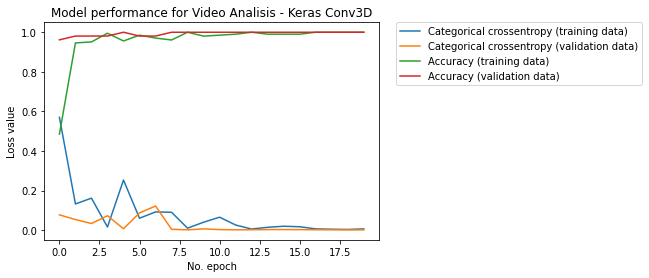

In [10]:
# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for Video Analisis - Keras Conv3D')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [14]:
# Saving model
filepath = './saved_model'

save_model(model, filepath)

INFO:tensorflow:Assets written to: ./saved_model\assets


1-Obtenido un 75% con un batch de 20 y un numero de 30 epochs.

2-Aumentando el batch a 100, 30 epochs, obtenemos un score de 100%. Pero testeando con otros videos, el resultado es de 29 aciertos sobre 30. El video en el que no acierta el modelo es un video de la impresion de una sola capa, de un pequeño rectangulo, con diferencia a los demas que imprimen varias capas. 

Se aprecia en el grafico que a partir de entre 20 y 25 epochs, el modelo no gana nada. Reduciremos el numero de epochs en 25.

Se ve en el grafico tambien que hay ligero overfitting entre los epochs 5-10 y 13-17 aproximadamente. Intentaremos reducir este overfitting con Dropout

3-El overfitting se ha reducido, por lo que nos quedamos con Dropout(). Obtenemos un score de 100% pero los videos cortos siguen sin clasificarse correctamente. Aun asi, podemos reducir todavia mas el numero de epochs a 20. Para subsanar el problema de los videos cortos que no se clasifican correctamente, amplio el numero de videos total a 500 (250+250). El batch se amplia a 150. ERROR, ordenador incapaz de hacerlo.
El batch se dejara en 150, pero reducimos el numero de videos a 205+205 segun lo siguiente:
Solucion alternativa, pasar mas videos problematicos (cortos) en los videos de entrenamiento. (añadidos 5 en cada una de las carpetas)

4-Mismo problema, reduciendo el batch a 120, eliminando los 5 ultimos videos, quedandonos con los videos cortos

5-Reducimos el batch a 100... Accuracy = 95%

6-Con otro ordenador, pasamos el batch a 200. Accuracy = 100%, pero acierta 124 de las 128 predicciones. Probemos con un batch de 150 para reducir el overfitting.

7-Con el batch de 150, y 20 epochs, tenemos una accuracy de 100%, y acierta 126 de las 128 predicciones. Es el mejor resultado obtenido.